In [42]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import math

# =========================
# 1. PARÁMETROS GLOBALES
# =========================

fs = 48000          # Frecuencia de muestreo (Hz)
symbol_rate = 1000   # Símbolos por segundo (ajustable)
Ts = 1.0 / symbol_rate
M = 2              # Cambia a 2, 4, 8 o 16

bits_per_symbol = int(np.log2(M))
assert 2**bits_per_symbol == M, "M debe ser potencia de 2"

# Banda de trabajo 4-12 kHz
f_min = 4000
f_max = 12000

# Frecuencias para cada símbolo
freqs = np.linspace(f_min, f_max, M)

# Preambulo: frecuencia fija (usamos la más baja)
f_preamble = freqs[0]
num_preamble_symbols = 20

# POSTÁMBULO (segmento de finalización) - NUEVO
f_postamble = freqs[-1]          # frecuencia distinta a la del preámbulo
num_postamble_symbols = 20       # número de símbolos de postámbulo
postamble_symbol_index = M - 1   # índice de símbolo para el postámbulo

# Silencios
silence_before = 0.5  # s
silence_after  = 0.5  # s

# Longitud de encabezado: número de bits para la longitud del mensaje (en caracteres)
HEADER_BITS = 16  # hasta 65535 caracteres


# ====================================
# 2. UTILIDADES DE CODIFICACIÓN/DECOD
# ====================================

def text_to_bits(s):
    """Convierte cadena ASCII a lista de bits (0/1)."""
    b = s.encode('ascii')
    bits = []
    for byte in b:
        for i in range(8):
            bits.append((byte >> (7 - i)) & 1)
    return bits

def bits_to_text(bits):
    """Convierte lista de bits (múltiplo de 8) a cadena ASCII."""
    if len(bits) % 8 != 0:
        raise ValueError("Número de bits no es múltiplo de 8")
    chars = []
    for i in range(0, len(bits), 8):
        byte_bits = bits[i:i+8]
        value = 0
        for bit in byte_bits:
            value = (value << 1) | bit
        chars.append(value)
    return bytes(chars).decode('ascii', errors='ignore')

def int_to_bits(n, num_bits):
    """Convierte entero n a lista de bits de longitud fija num_bits (MSB primero)."""
    bits = [(n >> (num_bits - 1 - i)) & 1 for i in range(num_bits)]
    return bits

def bits_to_int(bits):
    """Convierte lista de bits (MSB primero) a entero."""
    value = 0
    for bit in bits:
        value = (value << 1) | bit
    return value

def bits_to_symbols(bits, M):
    """Agrupa bits en símbolos 0..M-1."""
    k = int(np.log2(M))
    # Padding con ceros si no es múltiplo
    if len(bits) % k != 0:
        bits = bits + [0] * (k - (len(bits) % k))
    symbols = []
    for i in range(0, len(bits), k):
        value = 0
        for b in bits[i:i+k]:
            value = (value << 1) | b
        symbols.append(value)
    return symbols

def symbols_to_bits(symbols, M):
    """Convierte símbolos 0..M-1 a bits."""
    k = int(np.log2(M))
    bits = []
    for s in symbols:
        for i in range(k-1, -1, -1):
            bits.append((s >> i) & 1)
    return bits


# =============================
# 3. GENERACIÓN DE LA SEÑAL MFSK
# =============================

def generate_symbol_wave(symbol, Ts, fs, freqs, phase0=0.0):
    """Genera una senoide para un símbolo MFSK dado."""
    N = int(Ts * fs)
    t = np.arange(N) / fs
    f = freqs[symbol]
    wave = np.sin(2 * np.pi * f * t + phase0)
    # Podrías aplicar una ventana raised-cosine para reducir clics en bordes:
    # window = np.hanning(N)
    # wave *= window
    return wave

def generate_preamble(num_symbols, Ts, fs, f_preamble):
    """Genera un preámbulo de frecuencia fija."""
    Nsym = int(Ts * fs)
    t = np.arange(Nsym) / fs
    sym = np.sin(2 * np.pi * f_preamble * t)
    pre = []
    for _ in range(num_symbols):
        pre.append(sym.copy())
    return np.concatenate(pre)

# NUEVO: función para generar postámbulo
def generate_postamble(num_symbols, Ts, fs, f_postamble):
    """Genera un postámbulo de frecuencia fija (segmento de finalización)."""
    Nsym = int(Ts * fs)
    t = np.arange(Nsym) / fs
    sym = np.sin(2 * np.pi * f_postamble * t)
    post = []
    for _ in range(num_symbols):
        post.append(sym.copy())
    return np.concatenate(post)

def build_tx_signal(message, M, fs, Ts, freqs,
                    silence_before=0.5, silence_after=0.5,
                    num_preamble_symbols=20, f_preamble=None,
                    num_postamble_symbols=20, f_postamble=None):
    """Construye la señal completa lista para reproducir."""

    if f_preamble is None:
        f_preamble = freqs[0]
    if f_postamble is None:
        f_postamble = freqs[-1]

    # 1. Texto -> bits
    msg_bytes = message.encode('ascii')
    msg_len = len(msg_bytes)
    msg_bits = text_to_bits(message)

    # 2. Longitud -> bits de cabecera
    header_bits = int_to_bits(msg_len, HEADER_BITS)

    # 3. Concatenar header + datos
    total_bits = header_bits + msg_bits

    # 4. Bits -> símbolos
    symbols = bits_to_symbols(total_bits, M)

    # 5. Símbolos -> señal MFSK
    symbol_waves = []
    for s in symbols:
        symbol_waves.append(generate_symbol_wave(s, Ts, fs, freqs))
    data_wave = np.concatenate(symbol_waves)

    # 6. Preambulo
    preamble = generate_preamble(num_preamble_symbols, Ts, fs, f_preamble)

    # 7. Postámbulo - NUEVO
    postamble = generate_postamble(num_postamble_symbols, Ts, fs, f_postamble)

    # 8. Silencios inicial y final
    silence1 = np.zeros(int(silence_before * fs))
    silence2 = np.zeros(int(silence_after * fs))

    # 9. Señal final: silencio + preámbulo + datos + postámbulo + silencio
    tx_signal = np.concatenate([silence1, preamble, data_wave, postamble, silence2])

    # Normalizamos para evitar clipping
    tx_signal = tx_signal / np.max(np.abs(tx_signal)) * 0.8

    return tx_signal


# ==========================
# 4. GRAFICADO (Tx & Rx)
# ==========================

def plot_signal_and_spectrogram(signal, fs, title=""):
    """Grafica señal en el tiempo y su espectrograma."""
    t = np.arange(len(signal)) / fs

    plt.figure(figsize=(12, 4))
    plt.plot(t, signal)
    plt.title(f"Señal en el tiempo - {title}")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.specgram(signal, NFFT=1024, Fs=fs, noverlap=512)
    plt.title(f"Espectrograma - {title}")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Frecuencia [Hz]")
    plt.colorbar(label="dB")
    plt.tight_layout()
    plt.show()


# =====================================
# 5. DETECCIÓN DE INICIO / FIN (Rx)
# =====================================

def detect_activity(sig, fs, frame_ms=10, threshold_factor=3.0, min_active_ms=100):
    """
    Detecta rango [start, end] donde hay energía 'alta' en la señal.
    Usa RMS en ventanas cortas y compara contra el ruido.
    """
    frame_len = int(fs * frame_ms / 1000.0)
    if frame_len <= 0:
        frame_len = 1

    num_frames = len(sig) // frame_len
    rms_vals = []

    for i in range(num_frames):
        frame = sig[i*frame_len:(i+1)*frame_len]
        rms = np.sqrt(np.mean(frame**2) + 1e-12)
        rms_vals.append(rms)

    rms_vals = np.array(rms_vals)
    noise_est = np.median(rms_vals)  # estimación de ruido de fondo
    threshold = noise_est * threshold_factor

    active = rms_vals > threshold

    # Convertimos frames activos contiguos en un bloque
    min_active_frames = int(min_active_ms / frame_ms)

    # Buscar primer bloque suficientemente largo
    start_frame = None
    end_frame = None

    i = 0
    while i < len(active):
        if active[i]:
            # inicio de posible bloque
            j = i
            while j < len(active) and active[j]:
                j += 1
            # [i, j) es un bloque activo
            if (j - i) >= min_active_frames:
                start_frame = i
                end_frame = j
                break
            else:
                i = j
        else:
            i += 1

    if start_frame is None:
        # No se detectó nada
        return 0, len(sig)

    # Convertimos a índices de muestra
    start_sample = start_frame * frame_len
    end_sample = min(len(sig), end_frame * frame_len)

    return start_sample, end_sample


# ==================================
# 6. DEMODULACIÓN MFSK EN EL RECEPTOR
# ==================================

def demodulate_mfsk(rx_segment, fs, Ts, freqs, M):
    """Demodula una señal MFSK y devuelve lista de símbolos."""

    Nsym = int(Ts * fs)
    num_symbols = len(rx_segment) // Nsym

    symbols = []

    # Para detección de energía por frecuencia, pre-generamos sin/cos
    t_sym = np.arange(Nsym) / fs
    sin_table = [np.sin(2*np.pi*f*t_sym) for f in freqs]
    cos_table = [np.cos(2*np.pi*f*t_sym) for f in freqs]

    for k in range(num_symbols):
        sym_samples = rx_segment[k*Nsym:(k+1)*Nsym]
        energies = []
        for idx in range(M):
            s = sin_table[idx]
            c = cos_table[idx]
            I = np.sum(sym_samples * c)
            Q = np.sum(sym_samples * s)
            energy = I*I + Q*Q
            energies.append(energy)
        sym_idx = int(np.argmax(energies))
        symbols.append(sym_idx)

    return symbols

# NUEVO: quitar postámbulo del final
def strip_postamble(symbols_wo_preamble,
                    postamble_symbol=postamble_symbol_index,
                    num_postamble_symbols=num_postamble_symbols):
    """
    Dado un arreglo de símbolos SIN preámbulo, corta el bloque final
    de postámbulo (num_postamble_symbols símbolos iguales a postamble_symbol).
    """
    n = len(symbols_wo_preamble)
    if n == 0:
        return symbols_wo_preamble

    end_idx = n
    run = 0

    # recorre desde el final hacia atrás buscando una corrida larga del símbolo de postámbulo
    for i in range(n - 1, -1, -1):
        if symbols_wo_preamble[i] == postamble_symbol:
            run += 1
            if run >= num_postamble_symbols:
                end_idx = i  # inicio del bloque de postámbulo
        else:
            if run > 0:
                break

    # recorta todo a partir del inicio del bloque de postámbulo
    useful_symbols = symbols_wo_preamble[:end_idx]
    return useful_symbols

def decode_message_from_symbols(symbols, M,
                                num_preamble_symbols=num_preamble_symbols,
                                num_postamble_symbols=num_postamble_symbols,
                                postamble_symbol=postamble_symbol_index):
    """
    Asumiendo:
    [preambulo][header_bits][data_bits][postambulo]

    - preámbulo: num_preamble_symbols símbolos (se descartan)
    - postámbulo: num_postamble_symbols símbolos del símbolo postamble_symbol (se descartan)
    - header: HEADER_BITS bits
    - datos: mensaje ASCII
    """

    # 1. Eliminamos el preámbulo
    if len(symbols) <= num_preamble_symbols:
        raise ValueError("Demasiado pocos símbolos; no hay espacio ni para el preámbulo.")

    symbols_wo_pre = symbols[num_preamble_symbols:]

    # 2. Eliminamos el postámbulo del final
    symbols_clean = strip_postamble(symbols_wo_pre,
                                    postamble_symbol=postamble_symbol,
                                    num_postamble_symbols=num_postamble_symbols)

    # 3. Convertimos símbolos -> bits
    bits = symbols_to_bits(symbols_clean, M)

    # 4. Tomamos primero HEADER_BITS bits -> longitud del mensaje (en chars)
    if len(bits) < HEADER_BITS:
        raise ValueError("No hay suficientes bits para el header de longitud.")

    header_bits_list = bits[:HEADER_BITS]
    msg_len = bits_to_int(header_bits_list)

    # 5. Resto son bits de datos
    data_bits = bits[HEADER_BITS:]
    expected_data_bits = msg_len * 8

    if len(data_bits) < expected_data_bits:
        print("Advertencia: no hay suficientes bits para el mensaje indicado")
        used_bits = len(data_bits)
    else:
        used_bits = expected_data_bits

    data_bits = data_bits[:used_bits]

    # 6. Bits -> texto
    message = bits_to_text(data_bits)

    return message, msg_len


# ======================
# 7. TRANSMISOR (Tx)
# ======================

def transmit_message(message):
    tx_signal = build_tx_signal(message, M, fs, Ts, freqs,
                                silence_before=silence_before,
                                silence_after=silence_after,
                                num_preamble_symbols=num_preamble_symbols,
                                f_preamble=f_preamble,
                                num_postamble_symbols=num_postamble_symbols,   # NUEVO
                                f_postamble=f_postamble)                      # NUEVO
    print(f"Longitud mensaje: {len(message)} caracteres")
    print(f"Duración señal Tx: {len(tx_signal)/fs:.2f} s")

    # Graficar señal Tx
    plot_signal_and_spectrogram(tx_signal, fs, title="Transmisor")

    # Reproducir
    display(Audio(tx_signal, rate=fs))

    return tx_signal


# ======================
# 8. RECEPTOR (Rx)
# ======================

def record_and_receive(record_seconds=10.0):
    """
    Graba audio por micrófono, detecta inicio/fin de actividad,
    demodula MFSK y reconstruye mensaje.
    """
    print(f"Grabando durante {record_seconds} segundos... Reproduce la señal MFSK.")
    recording = sd.rec(int(record_seconds*fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    rx = recording[:, 0]

    print("Grabación completa. Longitud muestras:", len(rx))

    # Graficar señal cruda
    plot_signal_and_spectrogram(rx, fs, title="Recepción (cruda)")

    # Detectar actividad por energía
    start_idx, end_idx = detect_activity(rx, fs,
                                         frame_ms=10,
                                         threshold_factor=3.0,
                                         min_active_ms=100)

    rx_segment = rx[start_idx:end_idx]
    print(f"Segmento activo detectado de {start_idx/fs:.3f} s a {end_idx/fs:.3f} s "
          f"({len(rx_segment)/fs:.3f} s)")

    # Graficar segmento detectado
    plot_signal_and_spectrogram(rx_segment, fs, title="Recepción (segmento detectado)")

    # Demodular
    symbols = demodulate_mfsk(rx_segment, fs, Ts, freqs, M)

    print(f"Número de símbolos detectados: {len(symbols)}")

    # Decodificar mensaje usando preámbulo + postámbulo
    message, msg_len = decode_message_from_symbols(symbols, M,
                                                   num_preamble_symbols=num_preamble_symbols,
                                                   num_postamble_symbols=num_postamble_symbols,
                                                   postamble_symbol=postamble_symbol_index)
    print(f"Longitud declarada del mensaje: {msg_len} caracteres")
    print("Mensaje decodificado:")
    print(repr(message))

    return rx, rx_segment, symbols, message


# ============================
# 9. EJEMPLO DE USO PRÁCTICO
# ============================

# En el PC TRANSMISOR:
# message = "Hola Miguel, esto es una prueba MFSK con postámbulo!"
# tx_signal = transmit_message(message)
#
# En el PC RECEPTOR:
# rx, rx_segment, symbols, message_rx = record_and_receive(record_seconds=10.0)


Longitud mensaje: 45 caracteres
Duración señal Tx: 1.42 s


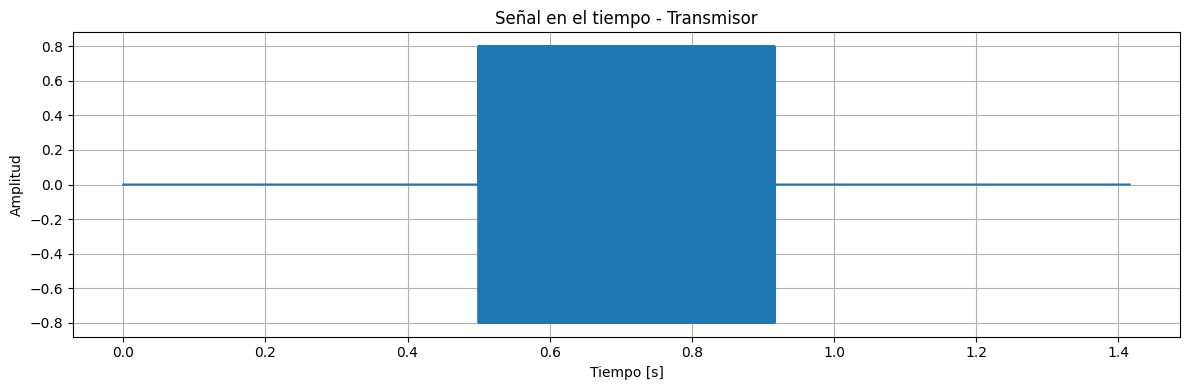

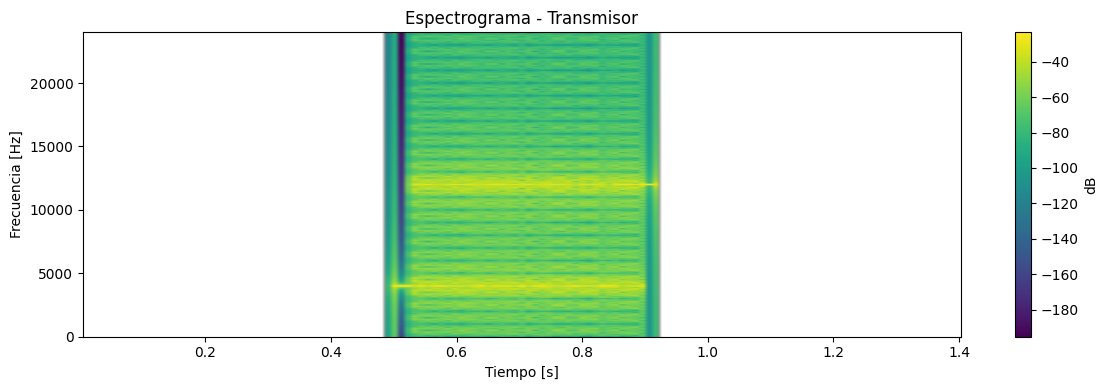

In [43]:
message = "Hola Miguel, esto es una prueba MFSK 8 tonos!"
tx_signal = transmit_message(message)

Grabando durante 5 segundos... Reproduce la señal MFSK.
Grabación completa. Longitud muestras: 240000


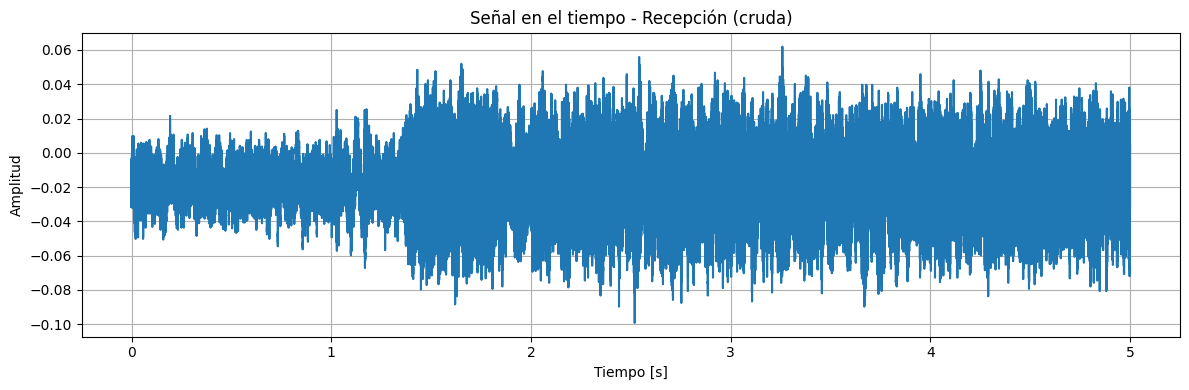

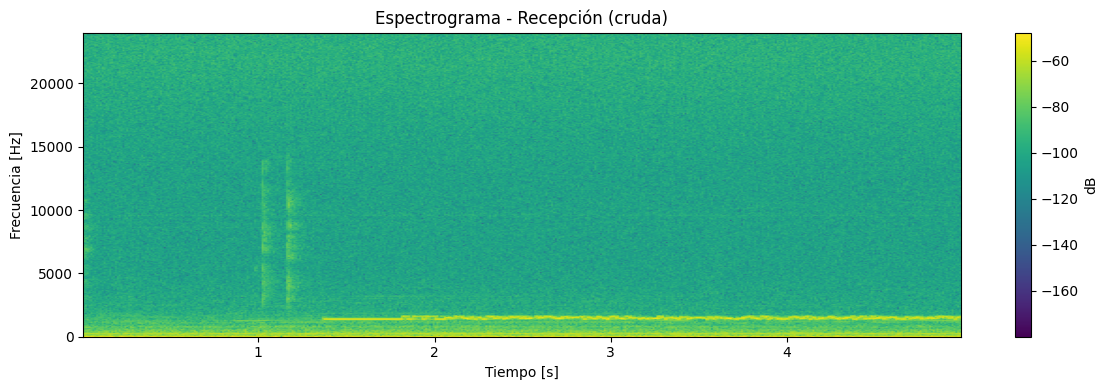

Segmento activo detectado de 0.000 s a 5.000 s (5.000 s)


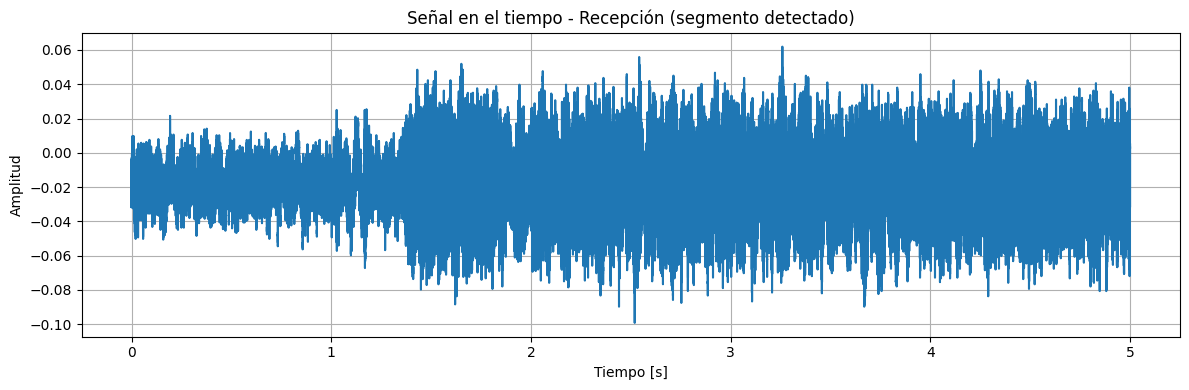

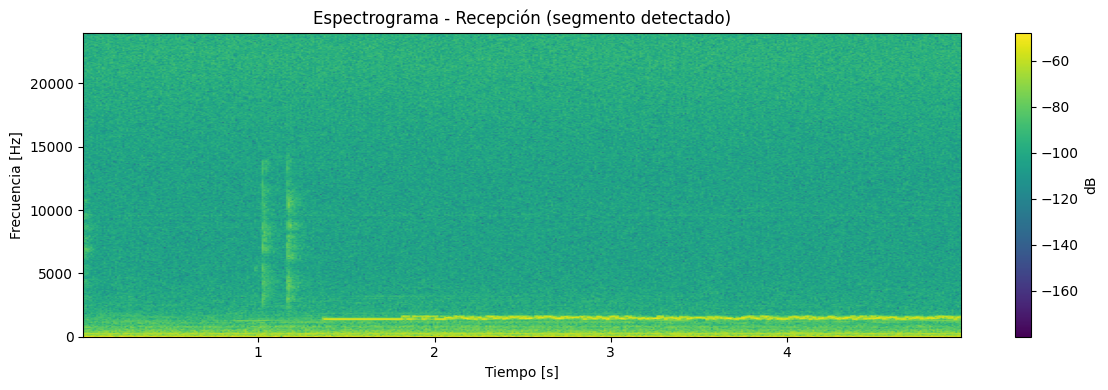

Número de símbolos detectados: 5000
Longitud declarada del mensaje: 9 caracteres
Mensaje decodificado:
' \x04B\x081'


In [46]:
rx, rx_segment, symbols, message_rx = record_and_receive(record_seconds=5)